<a href="https://colab.research.google.com/github/Deni1019/Bootcamp-Caracteristicas-del-mercado-energ-tico/blob/main/Demanda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip -q install prophet || pip -q install fbprophet
try:
    from prophet import Prophet
except Exception:
    from fbprophet import Prophet
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import t as student_t
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Ruta del archivo en el entorno actual
ruta = "data/carpeta_santi_estadistico/Variables Bootmcap.xlsx"

# Cargar el Excel
df = pd.read_excel(ruta)

# Mostrar información general
print("Dimensiones:", df.shape)
print("\nColumnas:", df.columns.tolist())

df_seleccion = df.iloc[:, [0, 24]]
df_seleccion.columns = ['Fecha', 'Demanda']

print("Vista rápida de df_seleccion:")
display(df_seleccion.head())

Dimensiones: (306, 70)

Columnas: ['Unnamed: 0', 'Inicio / Oferta y Generación / Generación / Generación Real del SIN / Descargar los datos de combustible fósil, hidráulica, biomasa, eólica y solar. Se agregan todas las fuentes para obtener la generación total) ', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Inicio / Hidrología / Reservas / Reservas Hídricas del SIN', 'Inicio / Hidrología / Reservas / Reservas Hídricas del SIN.1', 'Inicio / Hidrología / Reservas / Reservas Hídricas del SIN.2', 'Inicio / Transacciones y Precio / Contratos / Precios en contratos por tipo de mercado / Seleccionar mensual y descargar los datos', 'Inicio / Transacciones y Precio / Contratos / Precios en contratos por tipo de mercado / Seleccionar mensual y descargar los datos.1', 'Inicio / Oferta y Generación / Disponibilidad / Disponibilidad real / Descargar datos de Disponibilidad real promedio', 'Inicio / Oferta y Generación / Disponibilidad / Disponibilidad real / Descargar dat

,Fecha,Demanda
0,NaN,NaN
1,Fecha,Demanda real de energía [GWh] - total
2,2000-01-31 00:00:00,3261.730179
3,2000-02-29 00:00:00,3193.066156
4,2000-03-31 00:00:00,3413.141828


In [4]:
# --- 2) Adaptar al formato Prophet (ds, y) ---
dfp = df_seleccion.rename(columns={'Fecha':'ds','Demanda':'y'}).copy()
# Parseo robusto de fechas y numéricos
dfp['ds'] = pd.to_datetime(dfp['ds'], errors='coerce', dayfirst=True)
dfp['y']  = pd.to_numeric(dfp['y'], errors='coerce')

/tmp/ipykernel_6889/3096719169.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfp['ds'] = pd.to_datetime(dfp['ds'], errors='coerce', dayfirst=True)


In [5]:
# Limpieza: quitar nulos, ordenar, resolver duplicados por fecha (sum o mean según tu caso)
dfp = dfp.dropna(subset=['ds','y']).sort_values('ds')
dfp = dfp.groupby('ds', as_index=False)['y'].sum()

print("Frecuencia inferida:", pd.infer_freq(dfp['ds']) )
display(dfp.head())

Frecuencia inferida: None


,ds,y
0,2000-01-31,3261.730179
1,2000-02-29,3193.066156
2,2000-03-31,3413.141828
3,2000-04-30,3227.247348
4,2000-05-31,3407.109931


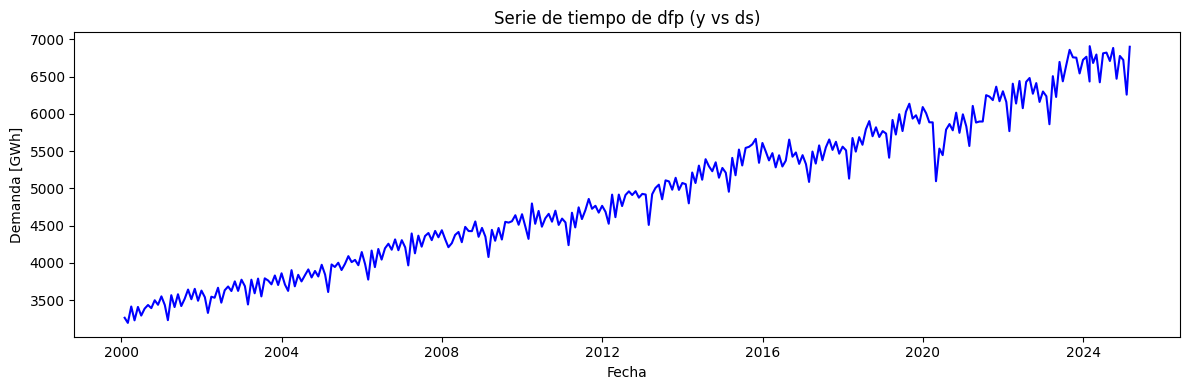

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(dfp["ds"], dfp["y"], color='blue')
plt.title("Serie de tiempo de dfp (y vs ds)")
plt.xlabel("Fecha")
plt.ylabel("Demanda [GWh]")
plt.tight_layout()
plt.show()

Frecuencia inferida: None


,ds,y
0,2000-01-31,3261.730179
1,2000-02-29,3193.066156
2,2000-03-31,3413.141828
3,2000-04-30,3227.247348
4,2000-05-31,3407.109931


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# === Prophet REGULARIZADO: Modelo + Gráfico completo ===


# -------- 0) Preparación básica y split --------
dfp = dfp.dropna(subset=['ds','y']).sort_values('ds')
dfp = dfp.groupby('ds', as_index=False)['y'].sum()
dfp['ds'] = pd.to_datetime(dfp['ds']); dfp['y'] = pd.to_numeric(dfp['y'], errors='coerce')
dfp = dfp.dropna(subset=['y']).reset_index(drop=True)
if pd.infer_freq(dfp['ds']) is None:
    dfp = (dfp.assign(ds=lambda d: d['ds'].dt.to_period('M').dt.to_timestamp(how='start'))
               .groupby('ds', as_index=False)['y'].sum())

N_TEST = 24
df_train = dfp.iloc[:-N_TEST].copy()
df_test  = dfp.iloc[-N_TEST:].copy()

# -------- 1) Cap/Floor si trabajas en logistic --------
use_logistic = 'cap' in df_train.columns or 'floor' in df_train.columns
if use_logistic:
    if 'cap' not in df_train.columns:
        cap_value = df_train['y'].max() * 1.15
        df_train['cap'] = cap_value; df_test['cap'] = cap_value
    if 'floor' not in df_train.columns:
        df_train['floor'] = 0.0; df_test['floor'] = 0.0

# -------- 2) Regresores disponibles --------
candidate_regs = ['covid_dummy', 'postcovid_dummy', 'ramp_postcovid']
reg_cols = [c for c in candidate_regs if c in df_train.columns]

# -------- 3) Modelo REGULARIZADO --------
m_reg = Prophet(
    growth=("logistic" if use_logistic else "linear"),
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.10,
    changepoint_range=0.90,
    n_changepoints=40,
    interval_width=0.90
)
m_reg.add_seasonality(name='yearly', period=365.25, fourier_order=10)

for c in reg_cols:
    mode = "additive" if "covid" in c else "multiplicative"
    m_reg.add_regressor(c, prior_scale=5.0, mode=mode)

fit_cols = ['ds','y'] + (['cap','floor'] if use_logistic else []) + reg_cols
m_reg.fit(df_train[fit_cols])

# -------- 4) Forecast completo (train + test) --------
future_reg = m_reg.make_future_dataframe(periods=len(df_test), freq='M')
if use_logistic:
    future_reg['cap'] = df_train['cap'].iloc[-1]
    future_reg['floor'] = df_train['floor'].iloc[-1]

for c in reg_cols:
    if c in df_train.columns:
        if c in ['covid_dummy','postcovid_dummy']:
            future_reg[c] = ((future_reg['ds'] >= df_train['ds'].min())).astype(int)
        elif c == 'ramp_postcovid':
            postcovid_ini = pd.to_datetime("2021-04-01")
            span_f = (future_reg['ds'].max() - postcovid_ini).days
            future_reg['ramp_postcovid'] = 0.0
            mask_f = future_reg['ds'] >= postcovid_ini
            future_reg.loc[mask_f, 'ramp_postcovid'] = (future_reg.loc[mask_f, 'ds'] - postcovid_ini).dt.days / max(span_f,1)

forecast_reg = m_reg.predict(future_reg)





21:40:41 - cmdstanpy - INFO - Chain [1] start processing
21:40:41 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/python/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


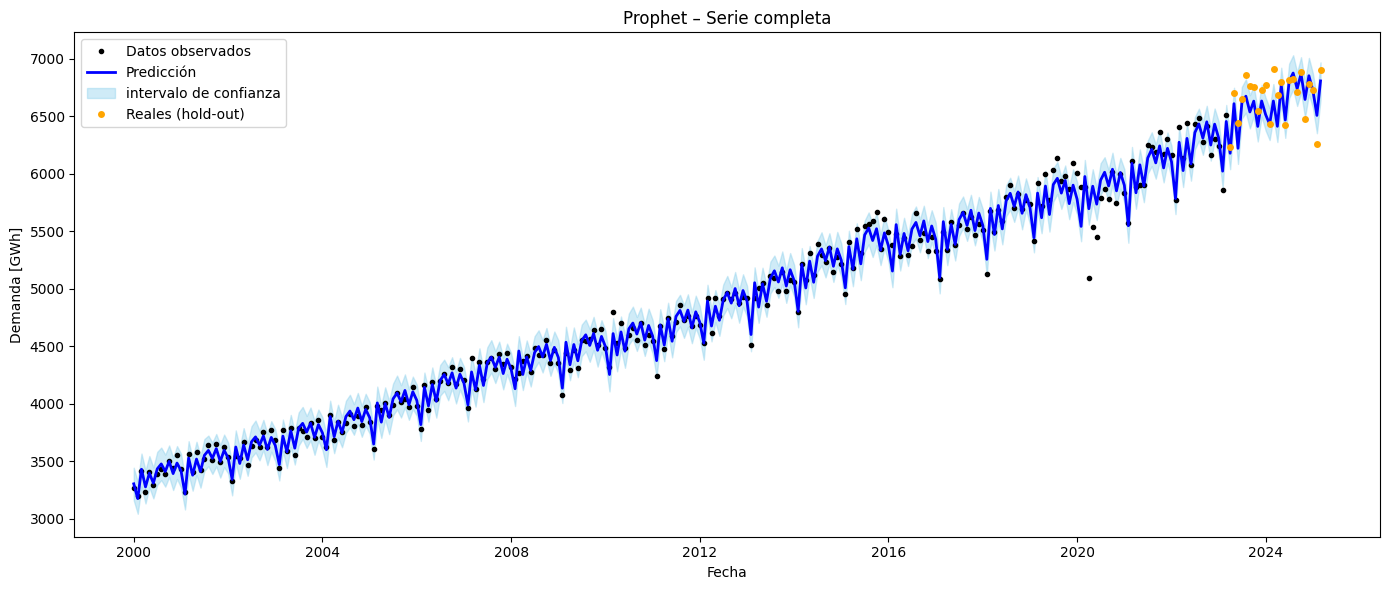

In [8]:
# -------- 5) Gráfico --------
plt.figure(figsize=(14,6))

# Observados (train)
plt.plot(df_train['ds'], df_train['y'], 'k.', label='Datos observados')

# Forecast central
plt.plot(forecast_reg['ds'], forecast_reg['yhat'], 'b-', label='Predicción', linewidth=2)

# Intervalo
plt.fill_between(forecast_reg['ds'], forecast_reg['yhat_lower'], forecast_reg['yhat_upper'],
                 color='skyblue', alpha=0.4, label='intervalo de confianza')

# Reales (test)
plt.plot(df_test['ds'], df_test['y'], 'o', mfc='orange', mec='none', mew=1, ms=5,
         label='Reales (hold-out)')

plt.title("Prophet – Serie completa")
plt.xlabel("Fecha"); plt.ylabel("Demanda [GWh]")
plt.legend(); plt.tight_layout(); plt.show()

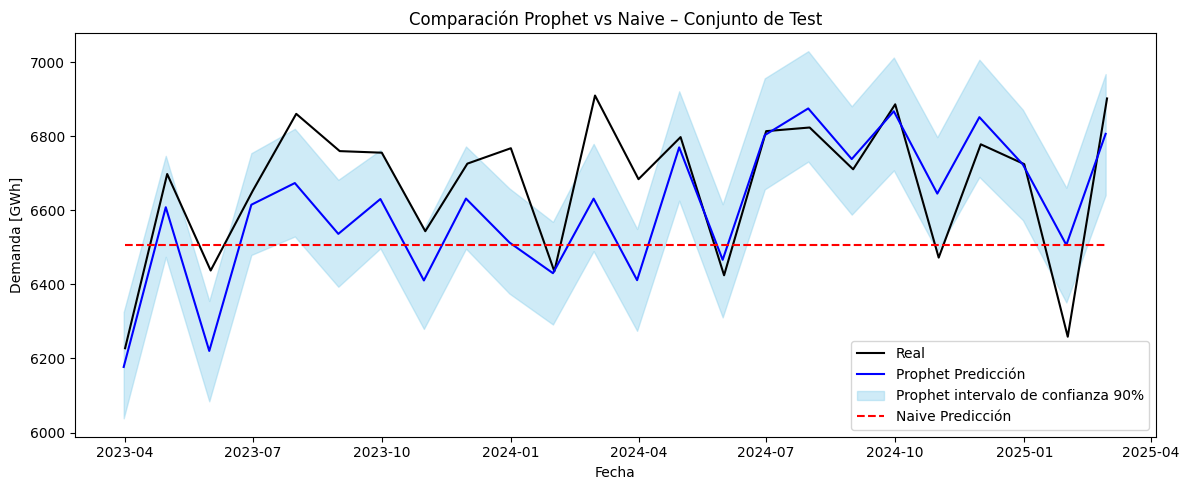

In [9]:
# === Gráfico comparativo: Prophet REGULARIZADO vs Naive (conjunto de Test) ===

# Extraer solo horizonte de test del forecast completo
fcst_test_reg = forecast_reg.tail(len(df_test))

plt.figure(figsize=(12,5))

# Serie real (test)
plt.plot(df_test['ds'], df_test['y'], 'k-', label='Real')

# Forecast Prophet REGULARIZADO
plt.plot(fcst_test_reg['ds'], fcst_test_reg['yhat'], 'b-', label='Prophet Predicción')

# Intervalo de incertidumbre
plt.fill_between(fcst_test_reg['ds'],
                 fcst_test_reg['yhat_lower'],
                 fcst_test_reg['yhat_upper'],
                 color='skyblue', alpha=0.4, label='Prophet intervalo de confianza 90%')

# Naive Forecast (último valor del train)
last_train_val = df_train['y'].iloc[-1]
naive_test_pred = np.full(len(df_test), last_train_val)
plt.plot(df_test['ds'], naive_test_pred, 'r--', label='Naive Predicción')

# Etiquetas y formato
plt.title("Comparación Prophet vs Naive – Conjunto de Test")
plt.xlabel("Fecha")
plt.ylabel("Demanda [GWh]")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:

# --- Prophet REGULARIZADO: métricas ---


# Forecasts separados de forecast_reg
fcst_train_reg = forecast_reg.iloc[:len(df_train)]
fcst_test_reg  = forecast_reg.iloc[-len(df_test):]

# Métricas Prophet
rmse_train = np.sqrt(mean_squared_error(df_train['y'], fcst_train_reg['yhat']))
mape_train = mean_absolute_percentage_error(df_train['y'], fcst_train_reg['yhat']) * 100

rmse_test  = np.sqrt(mean_squared_error(df_test['y'], fcst_test_reg['yhat']))
mape_test  = mean_absolute_percentage_error(df_test['y'], fcst_test_reg['yhat']) * 100

# --- Modelo naive ---
# Train: lag-1
naive_train_pred = df_train['y'].shift(1)
rmse_train_naive = np.sqrt(mean_squared_error(df_train['y'][1:], naive_train_pred[1:]))
mape_train_naive = mean_absolute_percentage_error(df_train['y'][1:], naive_train_pred[1:]) * 100

# Test: todos igual al último valor del train
last_train_val = df_train['y'].iloc[-1]
naive_test_pred = np.repeat(last_train_val, len(df_test))
rmse_test_naive = np.sqrt(mean_squared_error(df_test['y'], naive_test_pred))
mape_test_naive = mean_absolute_percentage_error(df_test['y'], naive_test_pred) * 100

# --- Comparación ---
print("=== Prophet REGULARIZADO ===")
print(f"RMSE Train: {rmse_train:.2f} | MAPE Train: {mape_train:.2f}%")
print(f"RMSE Test:  {rmse_test:.2f} | MAPE Test:  {mape_test:.2f}%")

print("\n=== Naive ===")
print(f"RMSE Train: {rmse_train_naive:.2f} | MAPE Train: {mape_train_naive:.2f}%")
print(f"RMSE Test:  {rmse_test_naive:.2f} | MAPE Test:  {mape_test_naive:.2f}%")


=== Prophet REGULARIZADO ===
RMSE Train: 84.47 | MAPE Train: 1.16%
RMSE Test:  146.44 | MAPE Test:  1.71%

=== Naive ===
RMSE Train: 208.65 | MAPE Train: 3.62%
RMSE Test:  251.64 | MAPE Test:  3.38%


In [11]:


# --- Preparar predicciones Prophet (último modelo) y Naive sobre el mismo hold-out ---
# Si no existen, construimos ev_test_reg a partir de m_reg y df_test
if 'ev_test_reg' not in globals():
    candidate_regs = ['covid_dummy', 'postcovid_dummy', 'ramp_postcovid']
    reg_cols = [c for c in candidate_regs if c in df_test.columns]
    extra_cols = ['ds'] + (['cap','floor'] if 'cap' in df_test.columns else []) + reg_cols
    fcst_test_reg = m_reg.predict(df_test[extra_cols])
    ev_test_reg = df_test[['ds','y']].merge(fcst_test_reg[['ds','yhat']], on='ds', how='left')

y_test = ev_test_reg['y'].to_numpy(dtype=float)
yhat_prophet = ev_test_reg['yhat'].to_numpy(dtype=float)

# Naive: constante = último valor del train
last_train_val = float(df_train['y'].iloc[-1])
yhat_naive = np.full_like(y_test, fill_value=last_train_val, dtype=float)

# --- Diebold–Mariano test (con Newey–West y corrección de Harvey–Leybourne–Newbold) ---
def diebold_mariano(y_true, yhat_1, yhat_2, h=1, loss='MSE'):
    """
    Compara modelo 1 vs modelo 2 sobre el MISMO hold-out.
    loss: 'MSE' (cuadrática) o 'MAE' (absoluta)
    h: horizonte de pronóstico; para multi-step overlapped usa h>1 (NW con L=h-1)
    """
    y_true = np.asarray(y_true, float)
    yhat_1 = np.asarray(yhat_1, float)
    yhat_2 = np.asarray(yhat_2, float)
    if loss.upper() == 'MSE':
        d = (y_true - yhat_1)**2 - (y_true - yhat_2)**2
    elif loss.upper() == 'MAE':
        d = np.abs(y_true - yhat_1) - np.abs(y_true - yhat_2)
    else:
        raise ValueError("loss debe ser 'MSE' o 'MAE'")

    T = d.size
    d_bar = d.mean()

    # Newey–West HAC variance con kernel Bartlett
    if h > 1:
        L = max(1, h - 1)
    else:
        # regla simple data-driven cuando h=1
        L = int(np.floor(T**(1/3)))  # puedes ajustar
    d_c = d - d_bar
    gamma0 = np.dot(d_c, d_c) / T
    s = gamma0
    for k in range(1, L + 1):
        gamma_k = np.dot(d_c[k:], d_c[:-k]) / T
        w = 1.0 - k / (L + 1.0)
        s += 2.0 * w * gamma_k
    var_dbar = s / T
    dm = d_bar / (np.sqrt(var_dbar) + 1e-12)

    # Corrección HLN (Harvey–Leybourne–Newbold) y p-valor t-Student
    if h > 1:
        c = np.sqrt((T + 1 - 2*h + (h*(h-1))/T) / T)
    else:
        c = 1.0
    dm_hln = dm * c
    pval = 2 * (1 - student_t.cdf(np.abs(dm_hln), df=T - 1))

    return dm_hln, pval, d_bar, var_dbar

# Ejecutar DM para pérdidas cuadráticas (MSE) y absolutas (MAE)
# Interpreta: d_bar < 0 => el primer modelo (Prophet) tiene menor pérdida media que Naive (mejor)
dm_mse_stat, dm_mse_p, dbar_mse, _ = diebold_mariano(y_test, yhat_prophet, yhat_naive, h=1, loss='MSE')
dm_mae_stat, dm_mae_p, dbar_mae, _ = diebold_mariano(y_test, yhat_prophet, yhat_naive, h=1, loss='MAE')

print("=== Diebold–Mariano: Prophet (modelo 1) vs Naive (modelo 2) ===")
print(f"MSE:  DM={dm_mse_stat:.3f}  p-value={dm_mse_p:.4f}  d_bar={dbar_mse:.3f}  "
      f"({'Prophet mejor' if dbar_mse<0 else 'Naive mejor' if dbar_mse>0 else 'Empate'})")
print(f"MAE:  DM={dm_mae_stat:.3f}  p-value={dm_mae_p:.4f}  d_bar={dbar_mae:.3f}  "
      f"({'Prophet mejor' if dbar_mae<0 else 'Naive mejor' if dbar_mae>0 else 'Empate'})")


=== Diebold–Mariano: Prophet (modelo 1) vs Naive (modelo 2) ===
MSE:  DM=-4.814  p-value=0.0001  d_bar=-45505.479  (Prophet mejor)
MAE:  DM=-4.120  p-value=0.0004  d_bar=-117.604  (Prophet mejor)


21:41:09 - cmdstanpy - INFO - Chain [1] start processing
21:41:10 - cmdstanpy - INFO - Chain [1] done processing


/usr/local/python/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


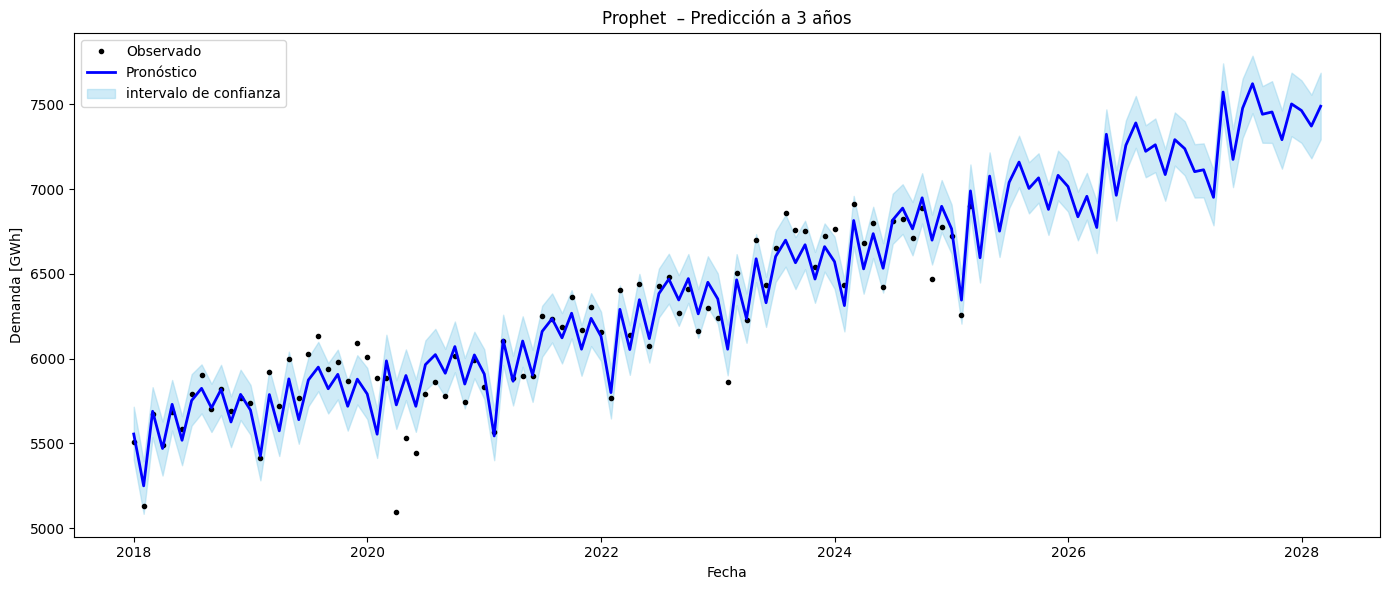

In [12]:
# -------- 0) Preparación de datos --------
dfp = dfp.dropna(subset=['ds','y']).sort_values('ds')
dfp = dfp.groupby('ds', as_index=False)['y'].sum()
dfp['ds'] = pd.to_datetime(dfp['ds'])
dfp['y']  = pd.to_numeric(dfp['y'], errors='coerce')
dfp = dfp.dropna(subset=['y']).reset_index(drop=True)

if pd.infer_freq(dfp['ds']) is None:
    dfp = (dfp.assign(ds=lambda d: d['ds'].dt.to_period('M').dt.to_timestamp(how='start'))
               .groupby('ds', as_index=False)['y'].sum())

# -------- 1) Cap/Floor si logistic --------
use_logistic = 'cap' in dfp.columns or 'floor' in dfp.columns
if use_logistic:
    if 'cap' not in dfp.columns:
        cap_value = dfp['y'].max() * 1.15
        dfp['cap'] = cap_value
    if 'floor' not in dfp.columns:
        dfp['floor'] = 0.0

# -------- 2) Regresores --------
candidate_regs = ['covid_dummy', 'postcovid_dummy', 'ramp_postcovid']
reg_cols = [c for c in candidate_regs if c in dfp.columns]

# -------- 3) Modelo REGULARIZADO --------
m_reg = Prophet(
    growth=("logistic" if use_logistic else "linear"),
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.10,
    changepoint_range=0.90,
    n_changepoints=40,
    interval_width=0.90
)
m_reg.add_seasonality(name='yearly', period=365.25, fourier_order=10)

for c in reg_cols:
    mode = "additive" if "covid" in c else "multiplicative"
    m_reg.add_regressor(c, prior_scale=5.0, mode=mode)

fit_cols = ['ds','y'] + (['cap','floor'] if use_logistic else []) + reg_cols
m_reg.fit(dfp[fit_cols])

# -------- 4) Predicción a 3 años --------
future = m_reg.make_future_dataframe(periods=36, freq='M')
if use_logistic:
    future['cap'] = dfp['cap'].iloc[-1]
    future['floor'] = dfp['floor'].iloc[-1]

for c in reg_cols:
    if c in dfp.columns:
        if c in ['covid_dummy','postcovid_dummy']:
            future[c] = ((future['ds'] >= dfp['ds'].min())).astype(int)
        elif c == 'ramp_postcovid':
            postcovid_ini = pd.to_datetime("2021-04-01")
            span_f = (future['ds'].max() - postcovid_ini).days
            future['ramp_postcovid'] = 0.0
            mask_f = future['ds'] >= postcovid_ini
            future.loc[mask_f, 'ramp_postcovid'] = (future.loc[mask_f, 'ds'] - postcovid_ini).dt.days / max(span_f,1)

forecast = m_reg.predict(future)

# Definir fecha de inicio para graficar
zoom_start = pd.to_datetime("2018-01-01")

plt.figure(figsize=(14,6))

# Observados desde 2018
mask_obs = dfp['ds'] >= zoom_start
plt.plot(dfp.loc[mask_obs, 'ds'], dfp.loc[mask_obs, 'y'], 'k.', label='Observado')

# Forecast desde 2018
mask_fcst = forecast['ds'] >= zoom_start
plt.plot(forecast.loc[mask_fcst, 'ds'], forecast.loc[mask_fcst, 'yhat'], 'b-', label='Pronóstico', linewidth=2)

# Intervalo de incertidumbre
plt.fill_between(forecast.loc[mask_fcst, 'ds'],
                 forecast.loc[mask_fcst, 'yhat_lower'],
                 forecast.loc[mask_fcst, 'yhat_upper'],
                 color='skyblue', alpha=0.4, label='intervalo de confianza')

plt.title("Prophet  – Predicción a 3 años")
plt.xlabel("Fecha"); plt.ylabel("Demanda [GWh]")
plt.legend(); plt.tight_layout(); plt.show()